In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))
import pandas as pd
import re
from wordcloud import STOPWORDS,WordCloud
import matplotlib.pyplot as plt


from clean_tweets_dataframe import Clean_Tweets


In [2]:
CSV_PATH = "../processed_tweet_data.csv"
CLEANED_SAVE_PATH = "../cleaned_tweet_data.csv"

## PreProcessing

In [3]:
# taking a csv file path and reading a dataframe

def read_proccessed_data(csv_path):
    try:    
        df = pd.read_csv(csv_path)
        print("file read as csv")
        return df
    except FileNotFoundError:
        print("file not found")
    
    

In [4]:
## getting number of columns, row and column information
def get_data_info(tweet_df: pd.DataFrame):
    
    row_count, col_count = tweet_df.shape
    
    print(f"Number of rows: {row_count}")
    print(f"Number of columns: {col_count}")

    return tweet_df.info()
    

In [5]:
# reading the extracted tweeter data and getting information

tweet_df = read_proccessed_data(CSV_PATH)
get_data_info(tweet_df)

file read as csv
Number of rows: 6532
Number of columns: 15
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6532 entries, 0 to 6531
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   created_at          6532 non-null   object 
 1   source              6532 non-null   object 
 2   original_text       6532 non-null   object 
 3   polarity            6532 non-null   float64
 4   subjectivity        6532 non-null   float64
 5   lang                6532 non-null   object 
 6   favorite_count      6532 non-null   int64  
 7   retweet_count       4785 non-null   float64
 8   original_author     6532 non-null   object 
 9   followers_count     6532 non-null   int64  
 10  friends_count       6532 non-null   int64  
 11  possibly_sensitive  0 non-null      float64
 12  hashtags            2655 non-null   object 
 13  user_mentions       5162 non-null   object 
 14  place               4088 non-null   object 


In [6]:
tweet_df.head()

,created_at,source,original_text,polarity,subjectivity,lang,favorite_count,retweet_count,original_author,followers_count,friends_count,possibly_sensitive,hashtags,user_mentions,place
0,Fri Jun 18 17:55:49 +0000 2021,"<a href=""http://twitter.com/download/iphone"" r...","🚨Africa is ""in the midst of a full-blown third...",0.166667,0.188889,en,548,612.0,ketuesriche,551,351,NaN,NaN,TelGlobalHealth WHOAFRO,Mass
1,Fri Jun 18 17:55:59 +0000 2021,"<a href=""https://mobile.twitter.com"" rel=""nofo...","Dr Moeti is head of WHO in Africa, and one of ...",0.133333,0.455556,en,195,92.0,Grid1949,66,92,NaN,NaN,globalhlthtwit,"Edinburgh, Scotland"
2,Fri Jun 18 17:56:07 +0000 2021,"<a href=""http://twitter.com/download/iphone"" r...",Thank you @research2note for creating this ama...,0.316667,0.483333,en,2,1.0,LeeTomlinson8,1195,1176,NaN,red4research,NHSRDForum Research2note NHSRDForum,NaN
3,Fri Jun 18 17:56:10 +0000 2021,"<a href=""https://mobile.twitter.com"" rel=""nofo...","Former Pfizer VP and Virologist, Dr. Michael Y...",0.086111,0.197222,en,1580,899.0,RIPNY08,2666,2704,NaN,NaN,HighWireTalk,NaN
4,Fri Jun 18 17:56:20 +0000 2021,"<a href=""http://twitter.com/download/android"" ...",I think it’s important that we don’t sell COVA...,0.280000,0.620000,en,72,20.0,pash22,28250,30819,NaN,NaN,PeterHotez,United Kingdom


In [7]:
# we can see that the only language used in the extracted data is english

tweet_df['lang'].value_counts()

en    6532
Name: lang, dtype: int64

In [8]:

get_data_info(tweet_df)

Number of rows: 6532
Number of columns: 15
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6532 entries, 0 to 6531
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   created_at          6532 non-null   object 
 1   source              6532 non-null   object 
 2   original_text       6532 non-null   object 
 3   polarity            6532 non-null   float64
 4   subjectivity        6532 non-null   float64
 5   lang                6532 non-null   object 
 6   favorite_count      6532 non-null   int64  
 7   retweet_count       4785 non-null   float64
 8   original_author     6532 non-null   object 
 9   followers_count     6532 non-null   int64  
 10  friends_count       6532 non-null   int64  
 11  possibly_sensitive  0 non-null      float64
 12  hashtags            2655 non-null   object 
 13  user_mentions       5162 non-null   object 
 14  place               4088 non-null   object 
dtypes: float64(4

In [9]:
# replacing hash tags, username starting by @ and links
def clean_text(text):
    hash_tag_removed = re.sub('(#[A-Za-z]+[A-Za-z0-9-_]+)', '', text)
    hash_tag_removed = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', text)

    removed_links = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text, flags=re.MULTILINE)
    cleaned = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', removed_links)
    cleaned = ''.join([i if ord(i) < 128 else ' ' for i in cleaned])
    
    cleaned = cleaned.strip()
    return cleaned

In [26]:
# function that extracts href link from <a> tag
# returns string representing link

def extract_source_link(tag: str) -> str:
    link_math = re.search(r'href=[\'"]?([^\'" >]+)', tag)
    return link_math.group(1)

In [11]:
# This function takes a Tweeter Data frame and returns a cleaned and preprocessed data frame.
# If save is true it saves the the return value

# we are going to use the imported Clean_Tweets to clean our extracted data
# Then we clean the original_text column
# We add a new column called clean_text to store the cleaned orignal text


def preprocess_and_clean(df: pd.DataFrame, save=False) -> pd.DataFrame:
    
    Tweet_cleaner = Clean_Tweets(df)
    
    df = Tweet_cleaner.drop_duplicate(df)
    
    df = Tweet_cleaner.drop_unwanted_column(df)
    
    df = Tweet_cleaner.drop_unwanted_column(df)
    
    df = Tweet_cleaner.convert_to_datetime(df)
    
    df = Tweet_cleaner.convert_to_numbers(df)
    
    df = Tweet_cleaner.remove_non_english_tweets(df)
    
    # handling missing values
    df = Tweet_cleaner.handle_missing_values(df)
    
    
    df['clean_text']= df['original_text'].astype(str)
    
    # changing to lower case
    
    df['clean_text'] = df['clean_text'].apply(lambda x: x.lower())
    
    # replacing common panctuations.
    
    df['clean_text']  = df['clean_text'].map(lambda x: re.sub('[,\.!?]', '', x))
    
    # applying clean_text function that we defined
    
    df['clean_text']  = df['clean_text'].apply(clean_text)
    
    
     # changing hashtags and place to lowercase
    df['hashtags'] = df['hashtags'].apply(lambda x: str(x).lower())
    df['place'] = df['place'].apply(lambda x: str(x).lower())
    
    # extract link from source
    df['source'] = df['source'].apply(extract_source_link)
    
    print("data cleaned...")
    df
    if save:
        try: 
            df.to_csv(CLEANED_SAVE_PATH, index=False)
            print('File Successfully Saved.!!!')
        
        except Exception:
            print("Save failed...")
    
    return df
            


    
    
    

In [12]:
# Preprocessing tweet_df and saving the result

preprocess_and_clean(tweet_df, True)

Automation in Action...!!!
data cleaned...
File Successfully Saved.!!!


,created_at,source,original_text,polarity,subjectivity,lang,favorite_count,retweet_count,original_author,followers_count,friends_count,possibly_sensitive,hashtags,user_mentions,place,clean_text
0,2021-06-18 17:55:49+00:00,http://twitter.com/download/iphone,"🚨Africa is ""in the midst of a full-blown third...",0.166667,0.188889,en,548,612.0,ketuesriche,551,351,0.0,,TelGlobalHealth WHOAFRO,mass,"africa is ""in the midst of a full-blown third ..."
1,2021-06-18 17:55:59+00:00,https://mobile.twitter.com,"Dr Moeti is head of WHO in Africa, and one of ...",0.133333,0.455556,en,195,92.0,Grid1949,66,92,0.0,,globalhlthtwit,"edinburgh, scotland",dr moeti is head of who in africa and one of t...
2,2021-06-18 17:56:07+00:00,http://twitter.com/download/iphone,Thank you @research2note for creating this ama...,0.316667,0.483333,en,2,1.0,LeeTomlinson8,1195,1176,0.0,red4research,NHSRDForum Research2note NHSRDForum,,thank you for creating this amazing campaign ...
3,2021-06-18 17:56:10+00:00,https://mobile.twitter.com,"Former Pfizer VP and Virologist, Dr. Michael Y...",0.086111,0.197222,en,1580,899.0,RIPNY08,2666,2704,0.0,,HighWireTalk,,former pfizer vp and virologist dr michael yea...
4,2021-06-18 17:56:20+00:00,http://twitter.com/download/android,I think it’s important that we don’t sell COVA...,0.280000,0.620000,en,72,20.0,pash22,28250,30819,0.0,,PeterHotez,united kingdom,i think it s important that we don t sell cova...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6527,2021-06-19 07:41:15+00:00,http://twitter.com/download/android,RT @Givenkazeni: Zweli please just release the...,0.000000,0.400000,en,188,54.0,Mthatos_Vivi,447,1089,0.0,,Givenkazeni,,rt : zweli please just release the graphic des...
6528,2021-06-19 07:41:26+00:00,http://twitter.com/download/android,"Former Pfizer VP and Virologist, Dr. Michael Y...",0.086111,0.197222,en,1595,908.0,wayno_af007,2224,2739,0.0,,HighWireTalk,"the boro, ma",former pfizer vp and virologist dr michael yea...
6529,2021-06-19 07:41:31+00:00,http://twitter.com/download/iphone,"@Jenfeds73 @DcrInYYC Respectfully, veterinaria...",0.281250,0.506250,en,0,0.0,dublonothing,3000,4709,0.0,,Jenfeds73 DcrInYYC,"los angeles, ca",respectfully veterinarians have to have a broa...
6530,2021-06-19 07:41:45+00:00,http://twitter.com/download/iphone,"""Africa needs millions more doses here &amp; n...",0.125000,0.325000,en,143,122.0,DrAmirKhanGP,135163,1284,0.0,covid19,WHOAFRO,yorkshire and the humber,"""africa needs millions more doses here &amp; n..."


## Data Exploration

In [13]:
# This is a class used to explore the tweeter data
# it expects a data frame to be instantiated

class TweeterDataExplorator:
    
    def __init__(self, df):
        
        self.df = df
    
    
    def read_head(self):
        return self.df.head()
    
    # returning the number of rows columns and column information
    def get_info(self):
        row_count, col_count = self.df.shape
    
        print(f"Number of rows: {row_count}")
        print(f"Number of columns: {col_count}")

        return (row_count, col_count), self.df.info()
    
    # gets number of distnict values in a given coumn
    def get_count(self, column_name):
        return self.df[column_name].value_counts()
    
    # returns the number of negative polarities, neutral polarities and positive polarities in a dict
    def get_polarities_count(self):
        postive_count = tweet_df[tweet_df['polarity'] > 0].shape[0]
        neutral_count = tweet_df[tweet_df['polarity'] == 0].shape[0]
        negative_count = tweet_df[tweet_df['polarity'] < 0].shape[0]
        
        return {"postive": postive_count, "neutral": neutral_count, "negative": negative_count}

        
    # constructs a hashtag data frame for every tweets and returns it
    def get_hash_tag_df(self):        
        hash_tags = self.df.clean_text.apply(self.__find_hashtags)
        
        flattened_hash_tags = []
        
        for hash_tag_list in hash_tags:
            for hash_tag in hash_tag_list:
                flattened_hash_tags.append(hash_tag)
        
        hashtag_df = pd.DataFrame(columns=['hashtag'])
        hashtag_df['hashtag'] = flattened_hash_tags
        
        return hashtag_df
    
    #  this returns the value count of top hash tags used in a data frame
    # if top is not specifed, it returns with a value count of every hashtag used
    def most_used_hash_tag(self, top=None):
        return self.get_hash_tag_df()['hashtag'].value_counts().head(top)
        
    def visualze_polarity(self):
        return 
    
    # returns value count of top language used
    # if top is not specifed, it returns with a value count of language of every language used
    def most_used_language(self, top=None):
        return self.df['lang'].value_counts().head(top)
    
    # returns value count of top users tweeted
    # if top is not specifed, it returns with a value count of language of every users who tweeted
    def authors(self, top=None): 
        return self.df['original_author'].value_counts().head(top)
    
    
    def most_retweeted_tweet(self):
        pass
    
    # private function that finds hash tags from a text
    def __find_hashtags(self, tweet):
        
        try:
            return re.findall('(#[A-Za-z]+[A-Za-z0-9-_]+)', tweet)
        except:
            return []

In [14]:
# reading the cleaned tweeter data
# creating an instance of tweeterDataExplorator

cleaned_tweet_df = read_proccessed_data(CLEANED_SAVE_PATH)
tweeterDataExplorator = TweeterDataExplorator(cleaned_tweet_df)

file read as csv


In [15]:
# inspecting the cleaned tweeter data
# We can see that the clean_text column has been added

cleaned_tweet_df

,created_at,source,original_text,polarity,subjectivity,lang,favorite_count,retweet_count,original_author,followers_count,friends_count,possibly_sensitive,hashtags,user_mentions,place,clean_text
0,2021-06-18 17:55:49+00:00,http://twitter.com/download/iphone,"🚨Africa is ""in the midst of a full-blown third...",0.166667,0.188889,en,548,612.0,ketuesriche,551,351,0.0,,TelGlobalHealth WHOAFRO,mass,"africa is ""in the midst of a full-blown third ..."
1,2021-06-18 17:55:59+00:00,https://mobile.twitter.com,"Dr Moeti is head of WHO in Africa, and one of ...",0.133333,0.455556,en,195,92.0,Grid1949,66,92,0.0,,globalhlthtwit,"edinburgh, scotland",dr moeti is head of who in africa and one of t...
2,2021-06-18 17:56:07+00:00,http://twitter.com/download/iphone,Thank you @research2note for creating this ama...,0.316667,0.483333,en,2,1.0,LeeTomlinson8,1195,1176,0.0,red4research,NHSRDForum Research2note NHSRDForum,,thank you for creating this amazing campaign ...
3,2021-06-18 17:56:10+00:00,https://mobile.twitter.com,"Former Pfizer VP and Virologist, Dr. Michael Y...",0.086111,0.197222,en,1580,899.0,RIPNY08,2666,2704,0.0,,HighWireTalk,,former pfizer vp and virologist dr michael yea...
4,2021-06-18 17:56:20+00:00,http://twitter.com/download/android,I think it’s important that we don’t sell COVA...,0.280000,0.620000,en,72,20.0,pash22,28250,30819,0.0,,PeterHotez,united kingdom,i think it s important that we don t sell cova...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6527,2021-06-19 07:41:15+00:00,http://twitter.com/download/android,RT @Givenkazeni: Zweli please just release the...,0.000000,0.400000,en,188,54.0,Mthatos_Vivi,447,1089,0.0,,Givenkazeni,,rt : zweli please just release the graphic des...
6528,2021-06-19 07:41:26+00:00,http://twitter.com/download/android,"Former Pfizer VP and Virologist, Dr. Michael Y...",0.086111,0.197222,en,1595,908.0,wayno_af007,2224,2739,0.0,,HighWireTalk,"the boro, ma",former pfizer vp and virologist dr michael yea...
6529,2021-06-19 07:41:31+00:00,http://twitter.com/download/iphone,"@Jenfeds73 @DcrInYYC Respectfully, veterinaria...",0.281250,0.506250,en,0,0.0,dublonothing,3000,4709,0.0,,Jenfeds73 DcrInYYC,"los angeles, ca",respectfully veterinarians have to have a broa...
6530,2021-06-19 07:41:45+00:00,http://twitter.com/download/iphone,"""Africa needs millions more doses here &amp; n...",0.125000,0.325000,en,143,122.0,DrAmirKhanGP,135163,1284,0.0,covid19,WHOAFRO,yorkshire and the humber,"""africa needs millions more doses here &amp; n..."


In [16]:
tweeterDataExplorator.get_info()

Number of rows: 6532
Number of columns: 16
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6532 entries, 0 to 6531
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   created_at          6532 non-null   object 
 1   source              6532 non-null   object 
 2   original_text       6532 non-null   object 
 3   polarity            6532 non-null   float64
 4   subjectivity        6532 non-null   float64
 5   lang                6532 non-null   object 
 6   favorite_count      6532 non-null   int64  
 7   retweet_count       6532 non-null   float64
 8   original_author     6532 non-null   object 
 9   followers_count     6532 non-null   int64  
 10  friends_count       6532 non-null   int64  
 11  possibly_sensitive  6532 non-null   float64
 12  hashtags            6532 non-null   object 
 13  user_mentions       6532 non-null   object 
 14  place               6532 non-null   object 
 15  clean_text  

((6532, 16), None)

In [17]:
polaritites_count = tweeterDataExplorator.get_polarities_count()
print(f"postive: { polaritites_count['postive'] }")
print(f"negative: { polaritites_count['negative'] }")
print(f"neutal: { polaritites_count['neutral'] }")

postive: 3426
negative: 1277
neutal: 1829


In [18]:
top_ten_hash_tags_used = tweeterDataExplorator.most_used_hash_tag(5)
top_ten_hash_tags_used

#covid19        2938
#vaccines        265
#africa          190
#coronavirus     169
#wecandothis     153
Name: hashtag, dtype: int64

In [19]:
top_ten_authors = tweeterDataExplorator.authors(5)
top_ten_authors

PuneUpdater        530
viralvideovlogs     45
WHO__India          27
Signal__Pump        27
Rosenchild          11
Name: original_author, dtype: int64

In [20]:
# VISUALZATION

<AxesSubplot:title={'center':'Top Authors'}>

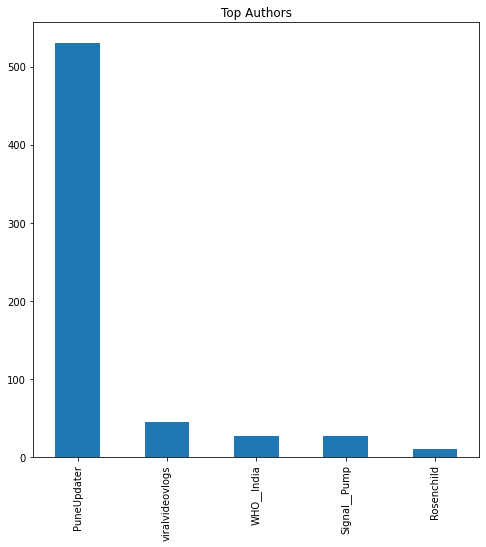

In [21]:
top_ten_authors.plot(kind="bar", title="Top Authors", figsize=[8, 8])

<AxesSubplot:title={'center':'Top authors'}, ylabel='original_author'>

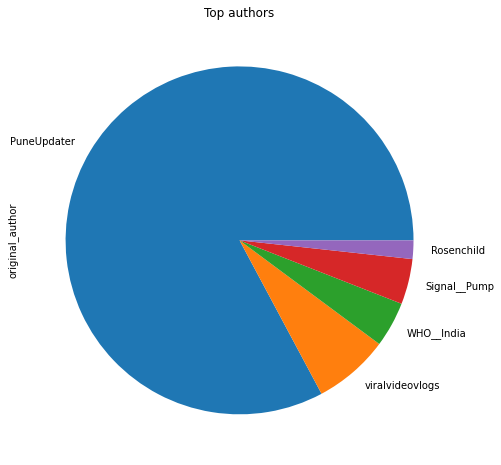

In [22]:
top_ten_authors.plot(kind="pie", title="Top authors", figsize=[8, 8])

<AxesSubplot:title={'center':'Frequent hashtags'}, ylabel='hashtag'>

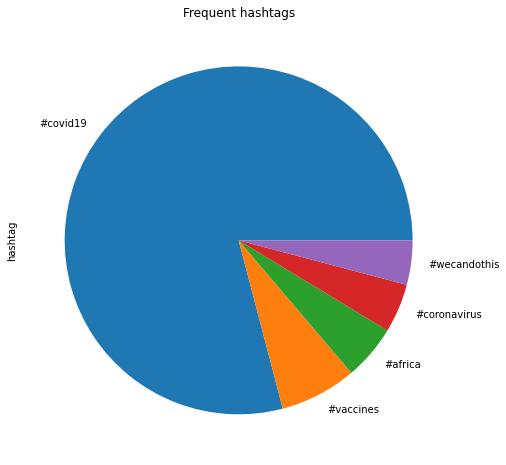

In [23]:
top_ten_hash_tags_used.plot(kind="pie", title="Frequent hashtags", figsize=[8, 8])

In [24]:
clean_text_df = pd.DataFrame(cleaned_tweet_df['clean_text'])
clean_text_df.dropna(inplace=True)
clean_text_df


,clean_text
0,"africa is ""in the midst of a full-blown third ..."
1,dr moeti is head of who in africa and one of t...
2,thank you for creating this amazing campaign ...
3,former pfizer vp and virologist dr michael yea...
4,i think it s important that we don t sell cova...
...,...
6527,rt : zweli please just release the graphic des...
6528,former pfizer vp and virologist dr michael yea...
6529,respectfully veterinarians have to have a broa...
6530,"""africa needs millions more doses here &amp; n..."


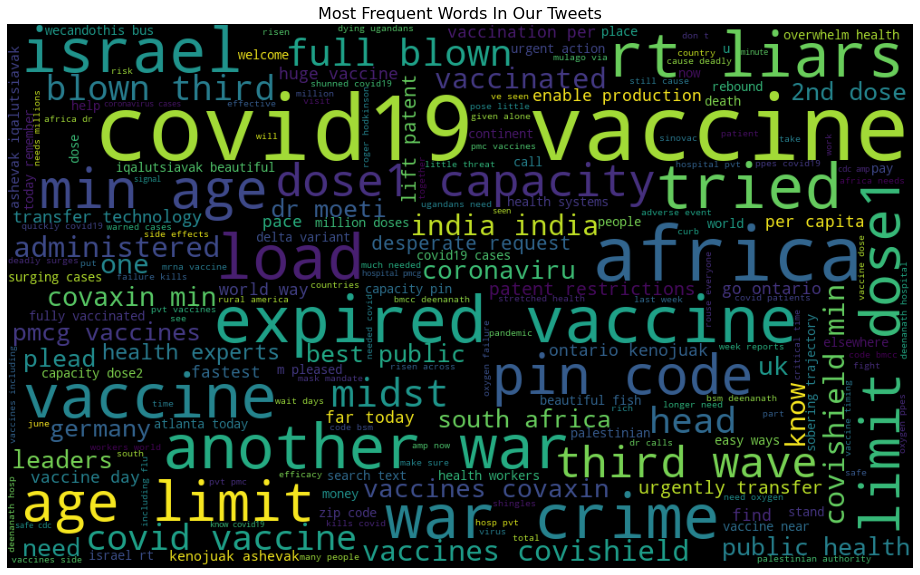

In [25]:
# using WordCloud to see which words used most


plt.figure(figsize=(20, 10))
plt.imshow(WordCloud(width=1000,height=600,stopwords=STOPWORDS).generate(' '.join(clean_text_df.clean_text)))
plt.axis('off')
plt.title('Most Frequent Words In Our Tweets',fontsize=16)
plt.show()